In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import GraphHelpers as GH
import ETFunctions as et
import MathsUtilities as MUte

## Bring in the data needed

### Met Data

In [4]:
MetData = pd.read_pickle('..\BroadFieldsMet.pkl')
DaylightIndex = MetData.IncomingRadnMJ.where(MetData.IncomingRadnMJ>0.002)
DaylightIndex.dropna(inplace=True)
DaylightIndex = DaylightIndex.index.tolist()
MetData.loc[:,'satVP'] = [et.saturated_vapor_pressure(MetData.loc[x,'AirTemperature'])/10 for x in MetData.index]
MetData.loc[:,'VP'] = [MetData.loc[x,'satVP']*MetData.loc[x,'RelativeHumidity']/100 for x in MetData.index]
MetData.loc[:,'VPD'] = MetData.satVP.subtract(MetData.VP)

DailyMet = MetData.IncomingRadnMJ.resample('D').sum()
DailyMet = pd.DataFrame(index=DailyMet.index,data=DailyMet.values,columns=['Radn'])
DailyMet.loc[:,'Temp'] = MetData.AirTemperature.resample('D').mean()
DailyMet.loc[:,'RH'] = MetData.RelativeHumidity.resample('D').mean()
DailyMet.loc[:,'VPD'] = MetData.loc[DaylightIndex,'VPD'].resample('D').mean()
MinVPD = 0.1
DailyMet.loc[:,'VP'] = MetData.VP.resample('D').mean()
DailyMet.loc[:,'VPD'] = DailyMet.loc[:,'VPD'].where(DailyMet.loc[:,'VPD']>MinVPD,MinVPD)
DailyMet.loc[:,'Wind'] = MetData.Windspeed.resample('D').mean()
DailyMet.loc[:,'Rainfall'] = MetData.loc[:,'Rainfall'].resample('D').sum()
DailyMet.loc[:,'PET'] = [et.PenmanEO(DailyMet.loc[x,'Radn'],
                                    DailyMet.loc[x,'Temp'],
                                    DailyMet.loc[x,'Wind'],
                                    DailyMet.loc[x,'VP'],
                                    'Total') for x in DailyMet.index]

AccumPET = DailyMet.PET.cumsum()

### CoverData

In [45]:
#Bring in fPAR (estimated from NDVI and interpolated to daily values) for each plot
BarleyfPAR = pd.concat([pd.read_pickle('..\Barley\DataFrames\DailyFPARTot.pkl')],axis=1,keys=['Barley'],names =['Crop'])
BarleyfPAR.columns = BarleyfPAR.columns.swaplevel('Cultivar','Irrigation')
#Rename cultivar treatment to Nitrogen in Barley so it can be treated the same as other crops
BarleyfPAR.columns.names = ['Depth', 'Irrigation', 'Nitrogen', 'Block']
WheatfPAR = pd.concat([pd.read_pickle('..\Wheat\DataFrames\DailyFPARTot.pkl')],axis=1,keys=['Wheat'],names =['Crop'])
FodderBeetfPAR = pd.concat([pd.read_pickle('..\FodderBeet\DataFrames\DailyFPARTot.pkl')],axis=1,keys=['FodderBeet'],names =['Crop'])
LucernefPAR = pd.read_pickle('..\LucerneAndPasture\DataFrames\LucDailyfPAREstInt.pkl')
RyegrassfPAR = pd.read_pickle('..\LucerneAndPasture\DataFrames\RyeDailyfPAREstInt.pkl')
OatsfPAR = pd.concat([pd.read_pickle('..\Oats\DataFrames\DailyFPARTot.pkl')],axis=1,keys=['Oats'],names =['Crop'])
fPAR = pd.concat([WheatfPAR,FodderBeetfPAR,LucernefPAR,RyegrassfPAR,OatsfPAR,BarleyfPAR],axis=1)
fPAR.dropna(how='all',inplace=True)
GH.SortFrame(fPAR)

### Top Soil Water

In [84]:
BarleyTopVWC = pd.concat([pd.read_pickle('..\Barley\DataFrames\TopVWC.pkl')],axis=1,keys=['Barley'],names = ['Crop'])
BarleyTopVWC.columns = BarleyTopVWC.columns.swaplevel('Cultivar','Irrigation')
#Rename cultivar treatment to Nitrogen in Barley so it can be treated the same as other crops
BarleyTopVWC.columns.names = ['Crop','Depth', 'Irrigation', 'Nitrogen', 'Block']
WheatTopVWC =  pd.concat([pd.read_pickle('..\Wheat\DataFrames\TopVWC.pkl')],axis=1,keys=['Wheat'],names = ['Crop'])
FodderBeetTopVWC =  pd.concat([pd.read_pickle('..\FodderBeet\DataFrames\TopVWC.pkl')],axis=1,keys=['FodderBeet'],names = ['Crop'])
OatsTopVWC =  pd.concat([pd.read_pickle('..\Oats\DataFrames\TopVWC.pkl')],axis=1,keys=['Oats'],names = ['Crop'])
LucerneTopVWC = pd.read_pickle('..\LucerneAndPasture\DataFrames\TopVWC.pkl').Lucerne
RyegrassTopVWC = pd.read_pickle('..\LucerneAndPasture\DataFrames\TopVWC.pkl').Ryegrass
TopVWC = pd.concat([BarleyTopVWC,WheatTopVWC,FodderBeetTopVWC,OatsTopVWC,LucerneTopVWC,RyegrassTopVWC])
TopVWC.columns = TopVWC.columns.swaplevel('Crop','Depth')

## Set graphics properties

In [89]:
Crops = TopVWC.columns.get_level_values(0).drop_duplicates().values
Crops.sort()
print('Wheat')
WheatGPs = GH.SetGraphicsPatterns(TopVWC.D1B.Wheat.columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['orange','green','purple'])
print('Barley')
FodderBeetGPs = GH.SetGraphicsPatterns(TopVWC.D1B.FodderBeet.columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['orange','green','purple'])
print('Lucerne')
LucerneGPs = GH.SetGraphicsPatterns(TopVWC.D1B.loc[:,['Lucerne','Ryegrass']].columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['red','blue','green','orange'],InvertLevels=True)
print('Ryegrass')
RyegrassGPs = GH.SetGraphicsPatterns(TopVWC.D1B.loc[:,['Lucerne','Ryegrass']].columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['red','blue','green','orange'],InvertLevels=True)
print('Oats')
OatsGPs = GH.SetGraphicsPatterns(TopVWC.D1B.Oats.columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['purple','green','orange'])
print('Barley')
BarleyGPs = GH.SetGraphicsPatterns(TopVWC.D1B.Barley.columns,
                    ['--','-'],
                    [0.45,0.15],
                    ['^','o'],
                    ['blue','red','green'])

Wheat
Irrigation
['Dryland', 'Irrigated']
Nitrogen
['0', '250', '50']
Treatments
MultiIndex(levels=[['Dryland', 'Irrigated'], ['0', '250', '50']],
           labels=[[0, 0, 0, 1, 1, 1], [0, 1, 2, 0, 1, 2]])
Styles
[('-', 'orange', 0.15, 'o'), ('-', 'green', 0.15, 'o'), ('-', 'purple', 0.15, 'o'), ('--', 'orange', 0.45, '^'), ('--', 'green', 0.45, '^'), ('--', 'purple', 0.45, '^')]
StyleFrame
              Lin     Col   Alp Mar     MFC
Dryland   0     -  orange  0.15   o  orange
          250   -   green  0.15   o   green
          50    -  purple  0.15   o  purple
Irrigated 0    --  orange  0.45   ^   white
          250  --   green  0.45   ^   white
          50   --  purple  0.45   ^   white
Barley
Irrigation
['Dryland', 'Irrigated']
Nitrogen
['0', '300', '50']
Treatments
MultiIndex(levels=[['Dryland', 'Irrigated'], ['0', '300', '50']],
           labels=[[0, 0, 0, 1, 1, 1], [0, 1, 2, 0, 1, 2]])
Styles
[('-', 'orange', 0.15, 'o'), ('-', 'green', 0.15, 'o'), ('-', 'purple', 0.15, 'o')

In [80]:
def MakeTimeSeriesGraphs(Data,name,ymin,ymax):
    Graph = plt.figure(figsize=(18,30))
    Crops = Data.columns.get_level_values(0).drop_duplicates().values
    Crops.sort()
    pos = 1
    for C in Crops:
        GP = globals()[C+'GPs']
        ax = Graph.add_subplot(3,2,pos)
        GH.AddIndexedPlot(Data.loc[:,C].dropna(how='all'),ax,GP,2)
        plt.ylabel(name, fontsize=36);
        plt.ylim(ymin,ymax)
        plt.tick_params(labelsize=20)
        plt.title(C, fontsize=28)
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=int(np.ceil(Data.loc[:,C].dropna(how='all').index.size/30/5))))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
        GH.AddLegend(1,16,'')
        pos+=1

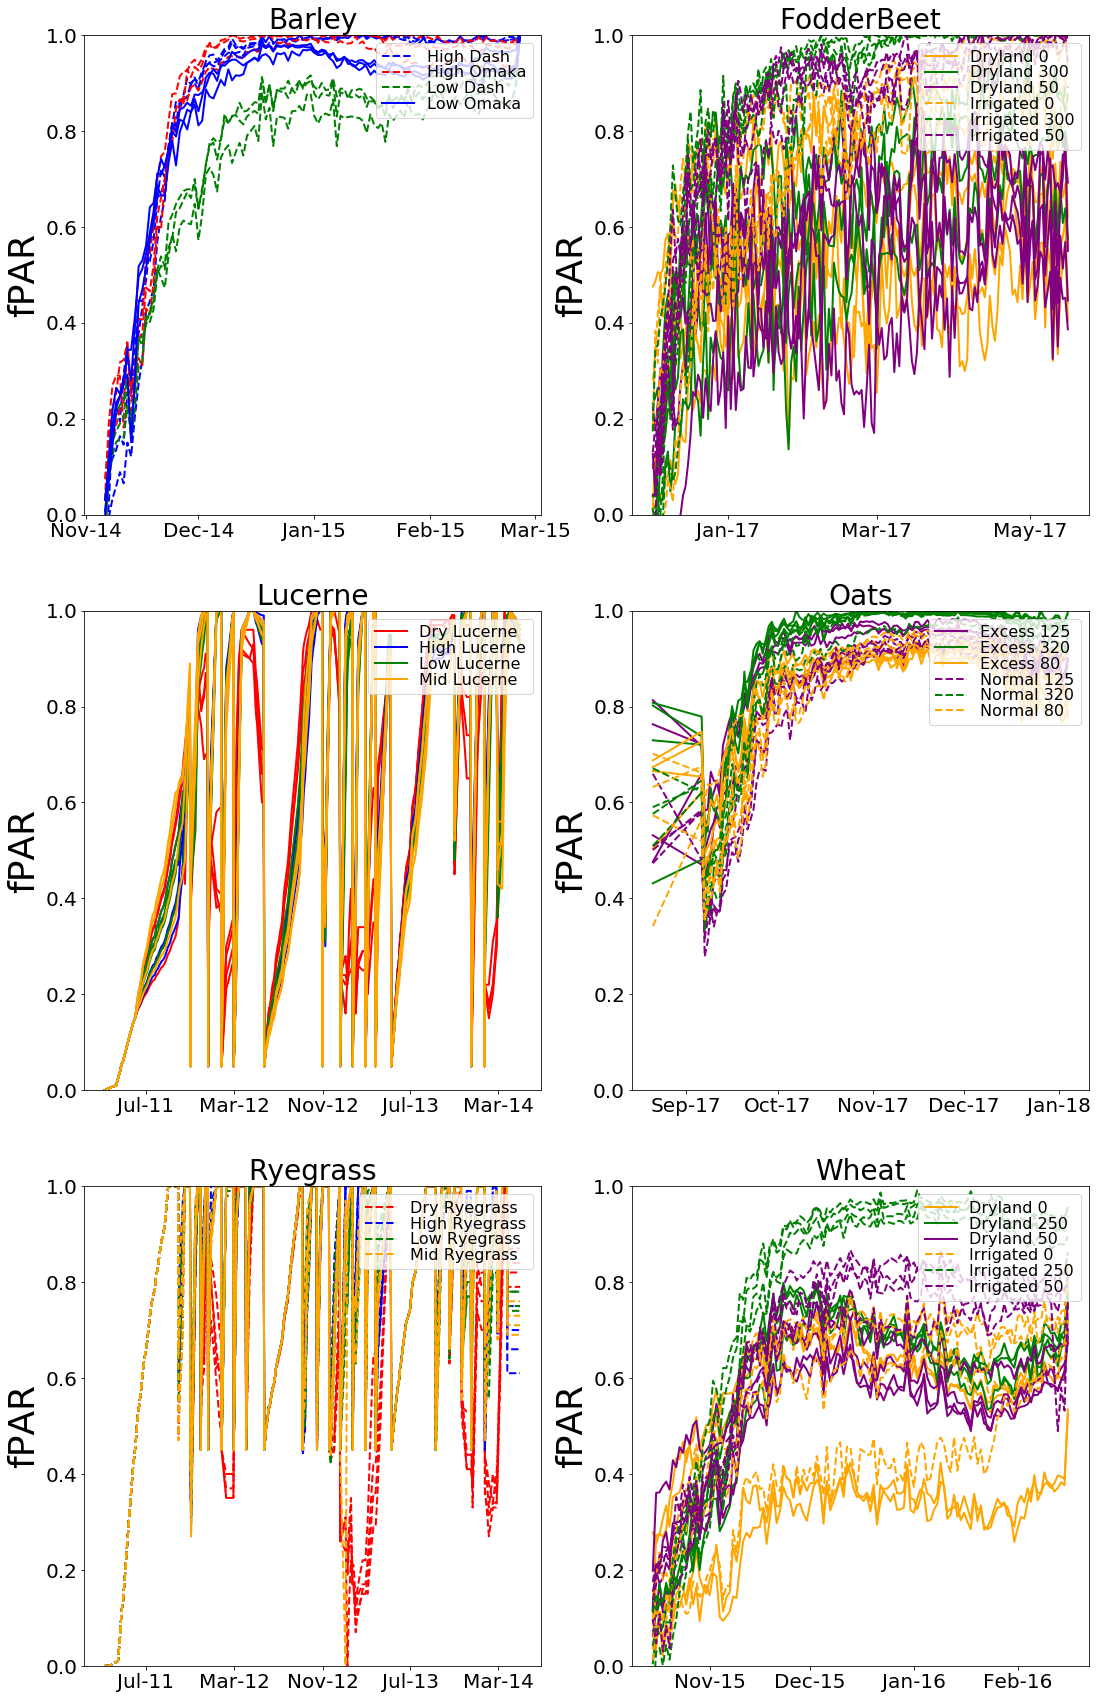

In [90]:
MakeTimeSeriesGraphs(fPAR,'fPAR',0,1)

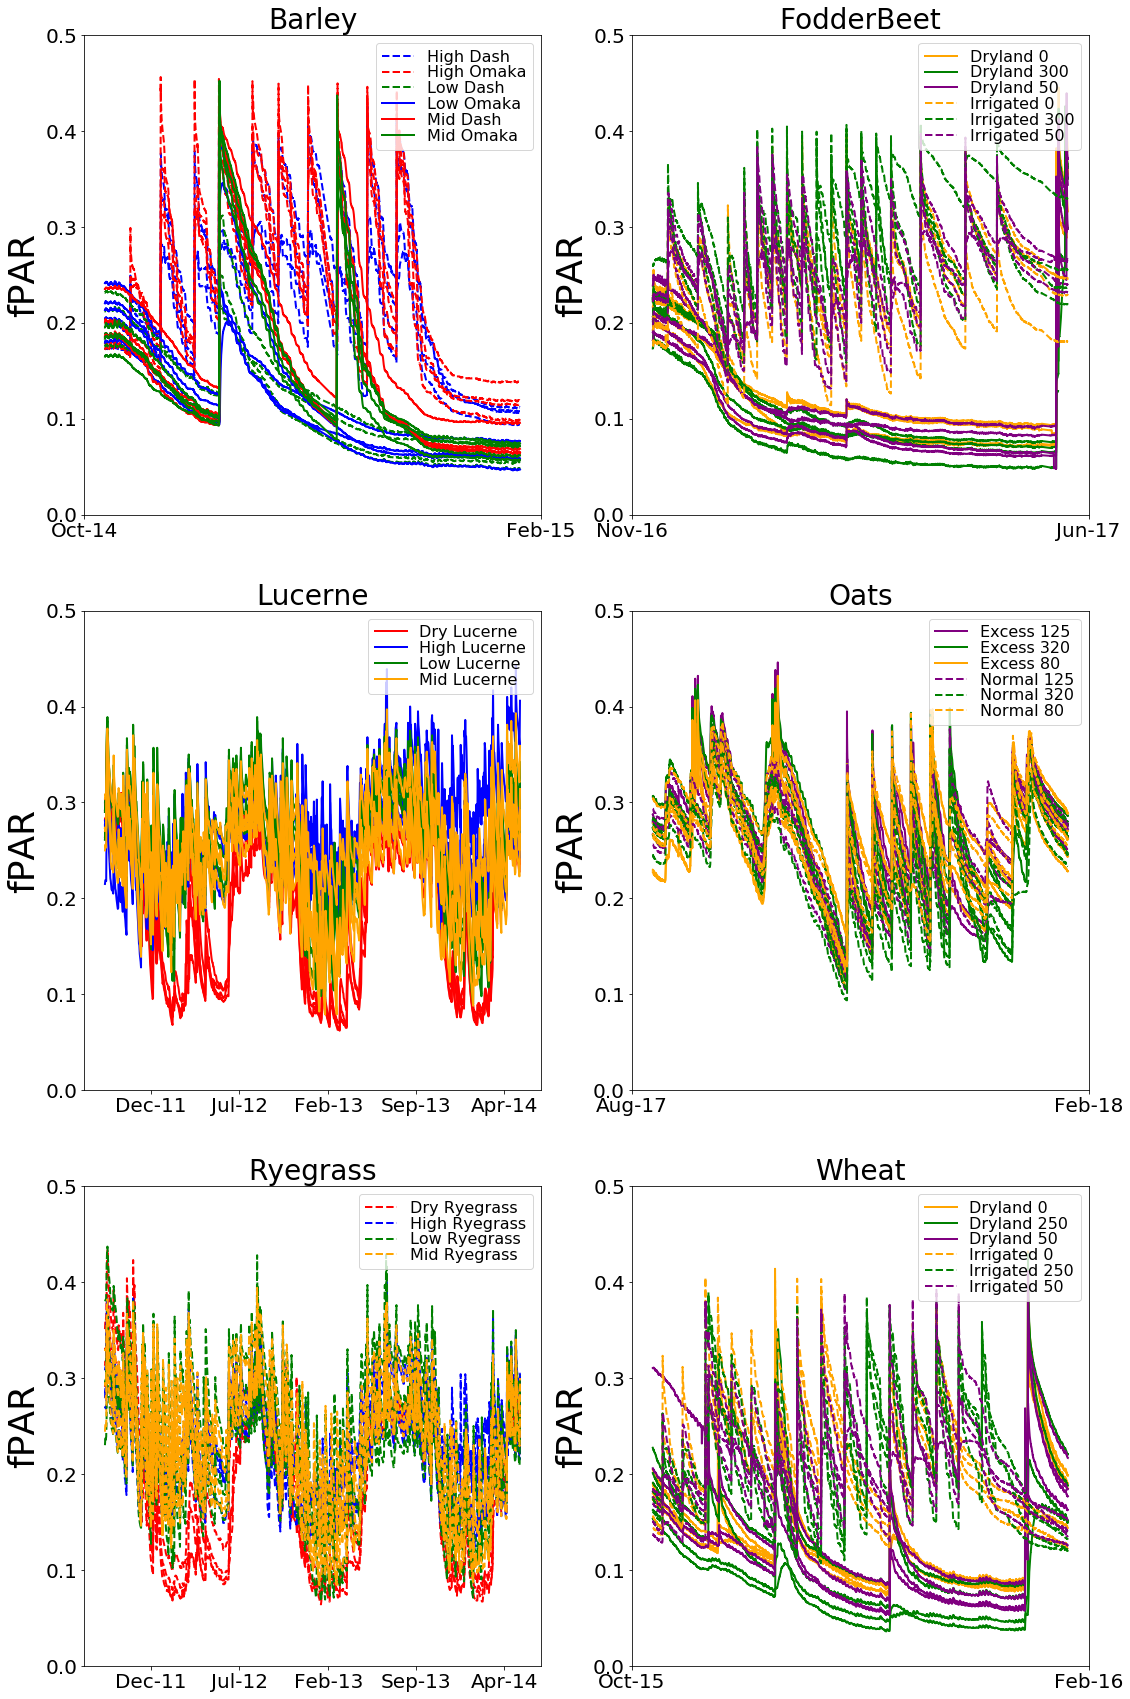

In [92]:
MakeTimeSeriesGraphs(TopVWC.D1B,'fPAR',0,0.5)